In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import transforms
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient

In [8]:
################# set up some plotting parameters #################
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
fontsize = 20


In [9]:
################# load sample data session #################
mouse_id = 'M427836'
col_vol_str = '51'
plane = 2
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session('M427836_11')

dff_traces = session.get_traces(trace_type='dff', plane=3)

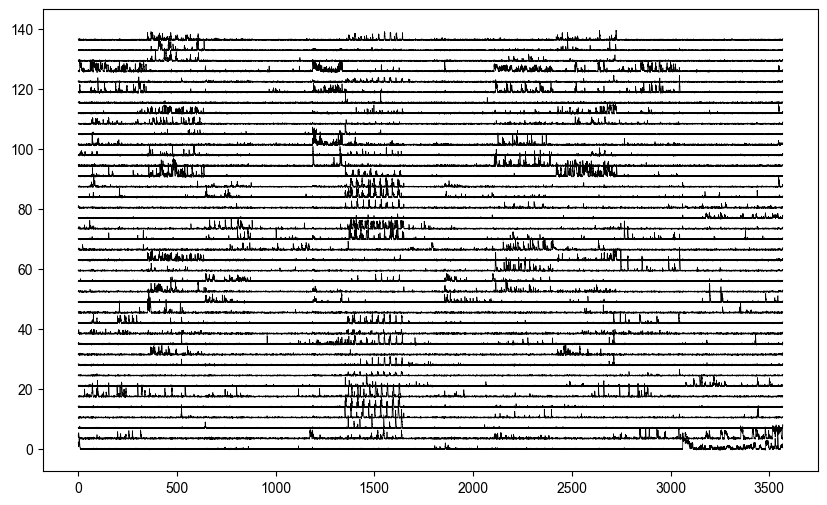

In [20]:
################# plot dF/F traces #################
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
for i, trace in enumerate(dff_traces.values[:40]):  # limit to first 40 traces for clarity
    plt.plot(dff_traces.time, trace + i * 3.5, color='black', linewidth=0.5)

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/matplotlib/transforms.py:2035: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


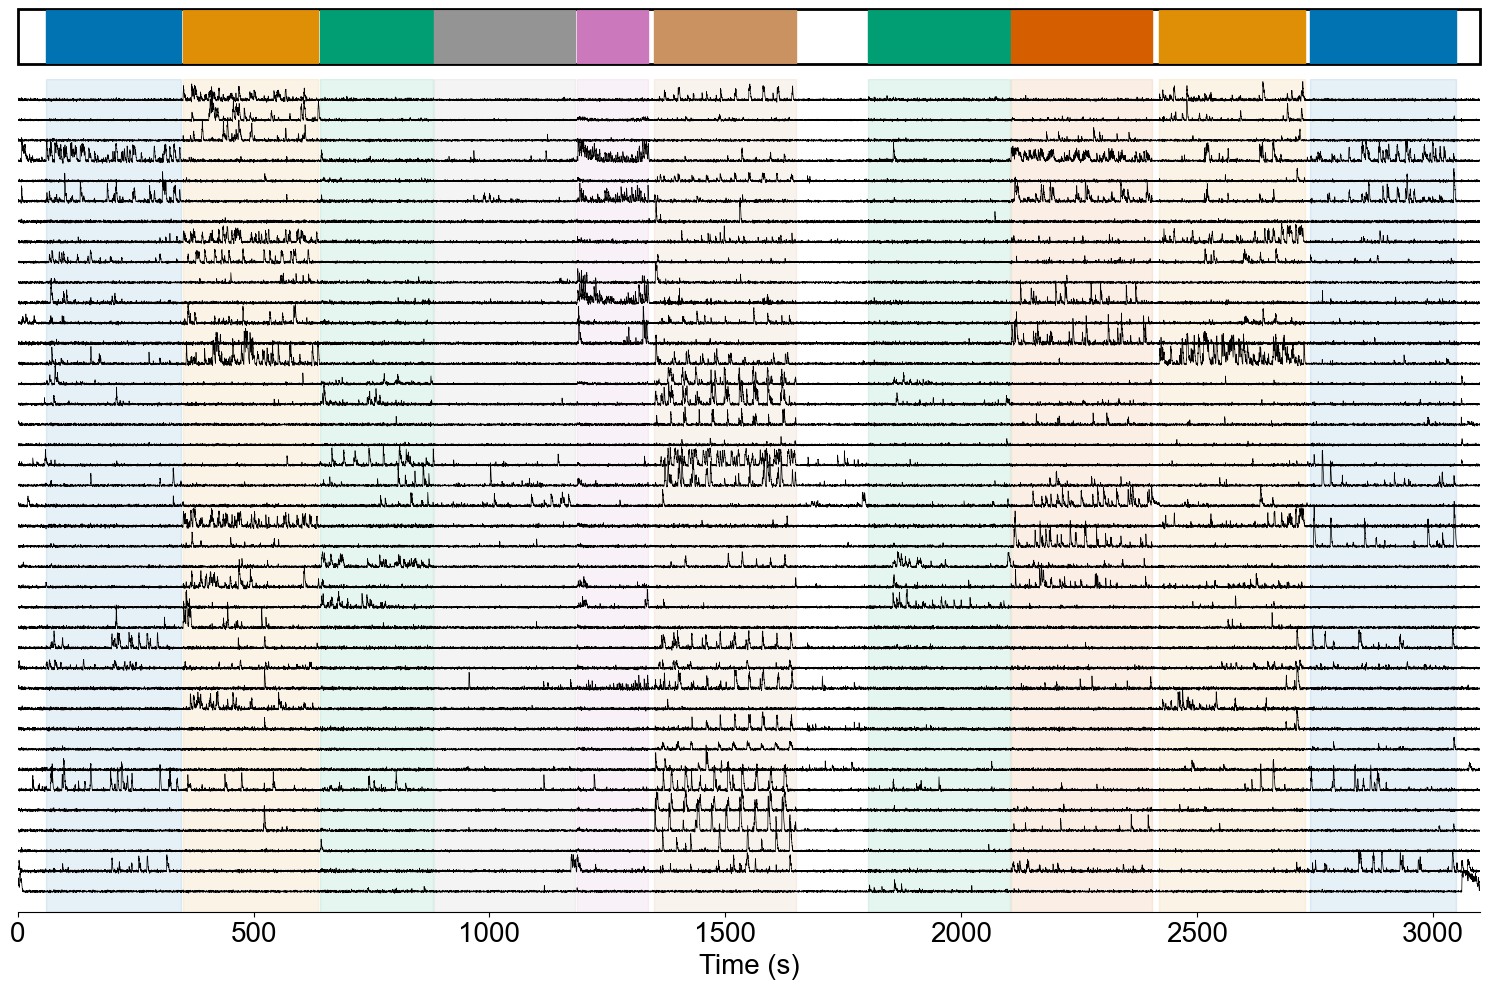

In [14]:
################# visualize sample data session #################
stims = [
    'drifting_gratings_full',
    'drifting_gratings_windowed',
    'locally_sparse_noise',
    'natural_images',
    'natural_images_12',
    'natural_movie',
    'spontaneous'
]
colors = sns.color_palette("colorblind", len(stims) + 1).as_hex()
stims_colors = {stim: color for stim, color in zip(stims, colors)}
stims_colors['spontaneous'] = colors[-1]  # Use the last color for spontaneous (grey)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 15]})

# Plotting the stimulus blocks
for stim, color in stims_colors.items():
    # print(f'Stimulus: {stim}, Color: {color}')
    stim_table = session.get_stimulus_table(stim_name=stim)[0]

    starts = stim_table.start.values
    ends = stim_table.end.values

    start_end_pairs = []
    min_start = starts.min()
    max_end = ends.min()
    for i, (start, end) in enumerate(zip(starts, ends)):
        # Check if the current end is more than 10 s after the previous start (end of the stimulus block)
        try: 
            if end > 10 + starts[i-1]:
                start_end_pairs.append((min_start, max_end))
                min_start = np.inf
                max_end = -np.inf
        except IndexError:
            pass

        # Check if at the end of the list to add the last pair
        try:
            ends[i+1]
        except IndexError:
            start_end_pairs.append((min_start, max_end))


        if start < min_start:
            min_start = start
        if end > max_end:
            max_end = end
            
    for start, end in start_end_pairs:
        axs[0].axvspan(start, end, color=color, alpha=1, label=stim)
        axs[1].axvspan(start, end, color=color, alpha=0.1, label=stim)

axs[0].set_yticks([])
axs[0].set_ylim(0, 0.1)
axs[0].set_xlim(left=0, right=3100)
axs[0].set_xticks([])
axs[0].patch.set_linewidth(2)
axs[0].patch.set_edgecolor('black')


# Plotting the dff traces
offset = 3.5  # vertical space between traces
time = dff_traces.time.values 
for i, trace in enumerate(dff_traces.values[:40]):  # limit to first 40 traces for clarity
    axs[1].plot(time, trace + i * offset, color='black', linewidth=0.5)

axs[1].set_xlabel('Time (s)', fontsize=fontsize)
axs[1].set_ylim(-offset, 40 * offset)
axs[1].set_xlim(left=0, right=3100)
axs[1].tick_params(axis='x', labelsize=fontsize)
axs[1].yaxis.set_visible(False)
axs[1].spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()

Explained variance ratios of temporal PCs: [0.01669972 0.00674146 0.00492466 0.00474955 0.00469531]


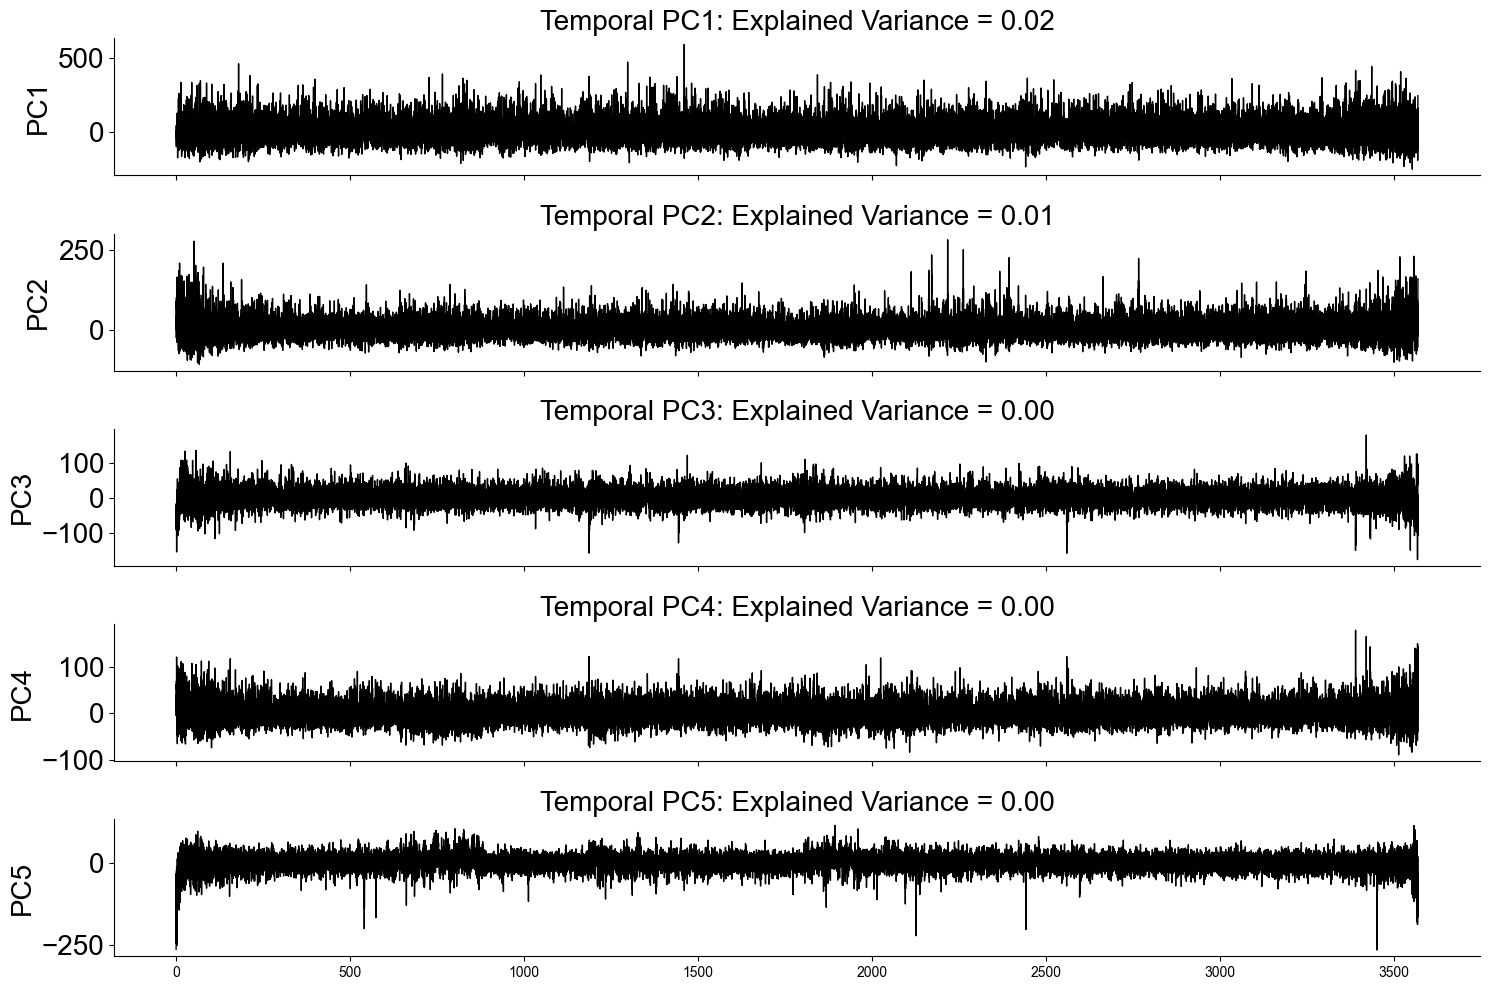

In [47]:
################### perform temporal PCA #################
## perform PCA on time derivatives of the dF/F traces
## this produces neuron weight vectors
## for each PC, a corresponding time-series (temporal PCA) can be obtained by projecting the original data onto the neuron weights

dff_deriv = np.gradient(dff_traces.values, axis=1)
pca_deriv = PCA(n_components=5)
pca_deriv_result = pca_deriv.fit_transform(dff_deriv)
pca_deriv_df = pd.DataFrame(data=pca_deriv_result, columns=[f'Temporal_PC{i+1}' for i in range(5)])
print(f'Explained variance ratios of temporal PCs: {pca_deriv.explained_variance_ratio_}')

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
time = dff_traces.time.values
for i in range(5):
    axs[i].plot(time, np.dot(dff_traces.T, pca_deriv_result[:, i]), color='black', linewidth=1)
    axs[i].set_title(f'Temporal PC{i+1}: Explained Variance = {pca_deriv.explained_variance_ratio_[i]:.2f}', fontsize=fontsize)
    axs[i].set_ylabel(f'PC{i+1}', fontsize=fontsize)
    axs[i].tick_params(axis='y', labelsize=fontsize)
    axs[i].spines[['top', 'right']].set_visible(False)

plt.tight_layout()

In [48]:
################### perform t-SNE on response features #################
from sklearn.manifold import TSNE

csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

res3 = ['frac_resp_dgf', 'frac_resp_dgw', 'frac_res_to_ns118', 'frac_res_to_ns12', 'frac_resp_nm']
stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

features = cell_info[res3]
features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'})

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T

##### perform t-SNE on the features
perplexity = 50
early_exaggeration = 12.0
learning_rate = 500

tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
embedding = tsne.fit_transform(features_stacked)

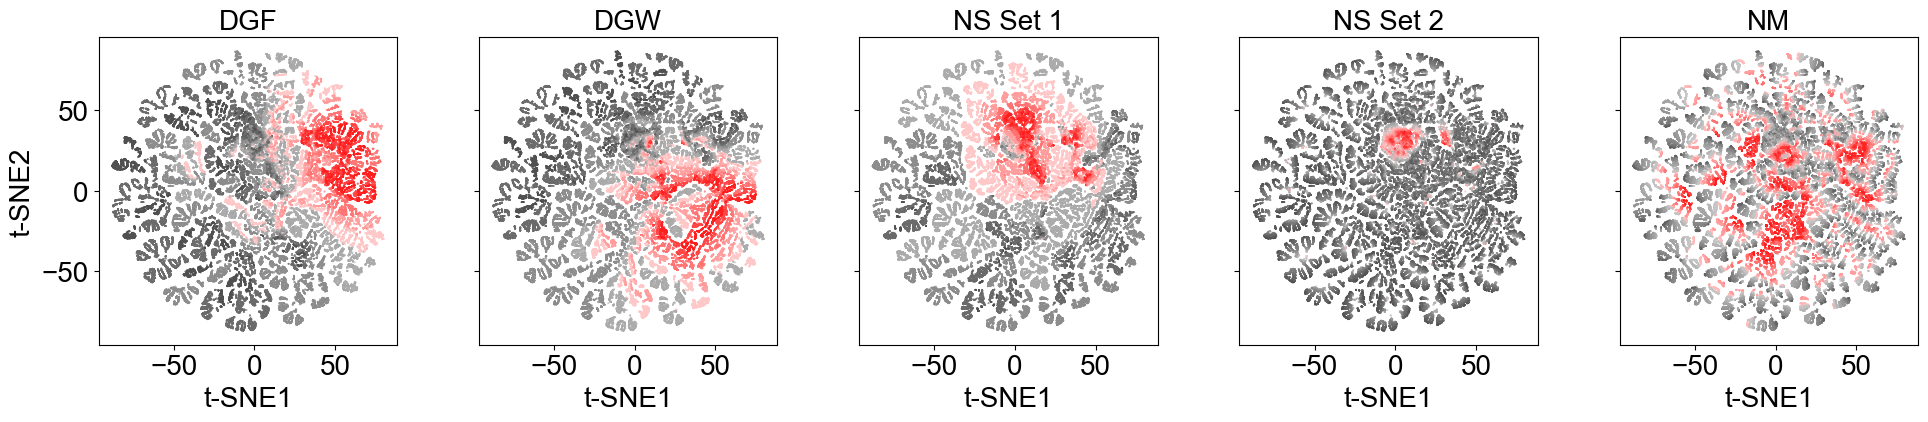

In [49]:
################### plot t-SNE on response features #################
from matplotlib.colors import LinearSegmentedColormap

fig, axs = plt.subplots(1, len(stim_names), figsize=(20, 4), sharex=True, sharey=True)
fontsize = 20

colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']
titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
unique_labels = np.unique(features_stacked)
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

for idx, stim_title in enumerate(titles):
    ax = axs[idx]
    X_subset_labels = features_stacked[:, idx]
    color_labels = np.array([label_to_color[label] for label in X_subset_labels])
    sc = ax.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            c=color_labels,
            cmap=custom_gray_cmap,
            alpha=1,
            s=0.1,

        )

    # plt.colorbar(sc, ax=ax)
    ax.set_aspect('equal')
    ax.set_title(stim_title, fontsize=fontsize)
    ax.set_xlabel('t-SNE1', fontsize=fontsize) 
    ax.set_ylabel('t-SNE2', fontsize=fontsize) if idx == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()

In [82]:
##################### perform kNN decoding #################
stimulus_type = 'drifting_gratings_windowed'

# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '23'
plane = 1
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
dff_traces = session.get_traces(trace_type='dff', plane=plane)

#### Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
# Load in stimulus table and drop any rows with NA values
stimulus_table, _ = session.get_stimulus_table(stimulus_type)
stimulus_table = stimulus_table.dropna()
stimulus_table = stimulus_table[
    stimulus_table["end"]
    < dff_traces.time.values[-1]
]

# Grab the start times and end times of each stimulus
stim_starts = stimulus_table.start.values
stim_ends = stimulus_table.end.values

# Iterate through each pair of start / end and calculate mean DFOF value during stimulus for each ROI
mean_dff_traces = []
all_rois = session.get_rois(plane)
for roi in all_rois:
    roi_mean_dff_trace = []
    roi_dff_trace = dff_traces[roi]
    for start, end in zip(stim_starts, stim_ends):
        start_idx = np.where(roi_dff_trace.time < start)[0][-1]
        end_idx = np.where(roi_dff_trace.time > end)[0][0]
        roi_mean_dff_trace.append(np.mean(roi_dff_trace[start_idx:end_idx].values))
    mean_dff_traces.append(roi_mean_dff_trace)

# Convert mean traces list into a dataframe and set column name as ROI index
mean_dff_traces_df = pd.DataFrame(data=mean_dff_traces).T
mean_dff_traces_df.columns = all_rois
X_data = mean_dff_traces_df.values

# Y data is the stimulus direction for each stimulus presentation
Y_data = stimulus_table.direction.values

# restrict to "good" ROIs
metrics_df = pd.read_csv("/home/naomi/Desktop/data/all_metrics_240426.csv")
rois = metrics_df[
    (metrics_df["mouse_id"] == "slc5") # figured this out manually 
    & (metrics_df["column"] == session.get_column_id())
    & (metrics_df["volume"] == str(session.get_volume_id()))
    & (
        metrics_df["plane"] == (plane - 1)
    )  # correct for 0-indexing in metrics_df
].cell_index.values
print(f"Number of ROIs before filtering: {X_data.shape[1]}")
X_data = X_data[:, rois]
print(f"Number of ROIs after filtering: {X_data.shape[1]}")

Number of ROIs before filtering: 1173
Number of ROIs after filtering: 372


In [83]:
X_data.shape, Y_data.shape

((192, 372), (192,))

In [97]:
from sklearn.neighbors import KNeighborsClassifier

n1 = int(0.8 * X_data.shape[0])
X_data_train = X_data[:n1]
Y_data_train = Y_data[:n1]
X_data_test = X_data[n1:]
Y_data_test = Y_data[n1:]

knn_model = KNeighborsClassifier(n_neighbors=8, metric='correlation')
knn_model.fit(X_data_train, Y_data_train)
Y_pred = knn_model.predict(X_data_test)

count = 0
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_data_test[i]:
        count += 1

accuracy = count / len(Y_pred)

print(f'kNN decoding accuracy: {accuracy:.3f}')

kNN decoding accuracy: 0.615


In [98]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)

# Perform k-nearest neighbors decoding
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print(f"Best number of neighbors (k): {best_k}")
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

Best number of neighbors (k): 7
Training accuracy: 0.6862745098039216
Test accuracy: 0.5641025641025641
